# **IN4080 - 2023**

# **Mandatory Assignment 2** - Alessia Sanfelici

**Part 1	– Exploring	the NLTK	tagger landscape**

**Exercise	1a:	Data	Split**

For our first experiments, we limit ourselves to the news section of the Brown corpus and split it into a 
training (90%) and a validation (10%) set. (We don’t need a test set for the moment, but will build one in 
part 3.) Moreover, we use the universal tagset instead of the default one.

You should store your data split in the variables news_train and news_val. Note that you may need 
to download the corpus first.

In [278]:
import nltk
nltk.download('universal_tagset')
from nltk.corpus import brown
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt 

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\sanfe\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [279]:
sents = brown.tagged_sents(categories = 'news', tagset = 'universal')

In [280]:
news_train, news_val = train_test_split(sents, test_size = 0.1, random_state = 42)

**Exercise 1b:	Most	Frequent	Class	Baseline**

The distribution of part-of-speech tags is typically quite skewed, with the most frequent class in general 
being common nouns. As a simple baseline, we should thus know how a model that always predicts the 
same (most frequent) class performs. This can be done with nltk.DefaultTagger. Note that we are using the universal tagset, so the 
most frequent tag is not named NN. Evaluate it on the validation set and report the accuracy

In [281]:
tags = [tag for (word, tag) in sents[0]]
max_tag = nltk.FreqDist(tags).max()
print("The most frequent tag is called", max_tag)

The most frequent tag is called NOUN


In [282]:
default_tagger = nltk.DefaultTagger('NOUN')
default_accuracy = default_tagger.accuracy(news_val)
print("Accuracy:")
print(default_accuracy)

Accuracy:
0.2996151189183855


The accuracy of this tagger is very low, we hope to improve it.

**Exercise	1c:	Naïve	Bayes	Unigram	Tagger**

One of the first models discussed in course is a Naïve Bayes classifier that relies only on the current word 
and does not take any context into account. This model is available as nltk.UnigramTagger. Report the accuracy on the 
validation set. How does the accuracy on the universal tagset differ from the one reported on the default 
tagset in the NLTK book?

In [283]:
unigram_tagger = nltk.UnigramTagger(news_train)
unigram_accuracy = unigram_tagger.accuracy(news_val)
print("Accuracy:")
print(unigram_accuracy)

Accuracy:
0.8853251751702359


The accuracy of Naïve Bayes classifier is way better than the previous case. 
However, the accuracy in this case results to be lower than the one reported on the default tagset in the NLTK book. It is lower of around 5%.

**Exercise	1d:	Bigram	HMM	Tagger**

In the lectures, we spent quite some time on the HMM tagger. Evaluate it on the validation set and report the result.

In [284]:
hmm = nltk.HiddenMarkovModelTagger.train(news_train)
hmm_accuracy = hmm.accuracy(news_val)
print("Accuracy:")
print(hmm_accuracy)

Accuracy:
0.9121681634264285


The performance is again improved, since the accuracy associated to HMM tagger reaches a value around 91,2%.

**Exercise	1e:	Perceptron	with	greedy	decoding**

In the lectures, we have shortly discussed Matthew Honnibal’s proposal of a structured perceptron
tagger with greedy decoding. He argued that an extended set of features is more helpful for tagging than 
exact (Viterbi) decoding. Evaluate it on the validation set and report the result.

In [285]:
perc = nltk.PerceptronTagger(load = False)
perc.train(news_train)
perc_accuracy = perc.accuracy(news_val)
print("Accuracy:")
print(perc_accuracy)

Accuracy:
0.9652620151978684


Summarize the results of the previous exercises and discuss them in a few sentences. Do the accuracies 
correspond to your expectations?

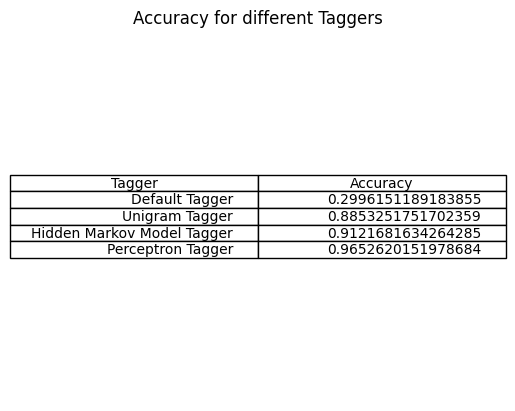

In [291]:
accuracies = [default_accuracy, unigram_accuracy, hmm_accuracy, perc_accuracy]
taggers = ["Default Tagger", "Unigram Tagger", "Hidden Markov Model Tagger", "Perceptron Tagger"]
dict_acc = {"Tagger": taggers, "Accuracy": accuracies}
df_accuracies = pd.DataFrame(dict_acc)
df_accuracies

fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText = df_accuracies.values, colLabels = df_accuracies.columns, loc = 'center')
ax.set_title("Accuracy for different Taggers")
plt.show()

The obtained results are shown in the previous table. The Defaul Tagger results to be the worst choice in this case, with an accuracy that is very small with respect to the other methods. For Unigram Tagger, HMM tagger and Perceptron tagger, the results are similar, but the best one is the Percepton tagger. Its accuracy is around 96.5%.

The accuracies reflect more or less what I expected. For the default tagger, it makes sense that its performance is bad, since it assigns a default tag for every word, thus it is not very accurate. As a consequence, it is not suitable for tasks where accuracy is essential. The other three methods perform better and also similarly. It is reasonable to think that HMM tagger works better than the Unigram tagger, since focusing only on the frequency of words can be a limit, while taking into account also the context of a word in a sentence can help and improve the performance of the tagger itself. Finally, I expected the structured Perceptron tagger to be the best one, since this method is able to perform well on a wide range of NLP tasks. This is due to the fact that this tagger learns tag probabilities from the training data, so it is a robust model which is able to contrast noisy data.

**Part	2	– Greedy	LR	taggers	and	feature	engineering**

**Exercise	2a:	Getting	started	with	a	greedy	logistic	regression tagger**

In [287]:
class ScikitGreedyTagger(nltk.TaggerI):
    def __init__(self, features, clf=LogisticRegression(max_iter = 400)):
        self.features = features
        self.classifier = clf
        self.vectorizer = DictVectorizer()

    def train(self, train_sents):
        train_feature_sets = []
        train_labels = []
        for tagged_sent in train_sents:
            history = []
            untagged_sent = nltk.tag.untag(tagged_sent)
            for i, (word, tag) in enumerate(tagged_sent):
                feature_set = self.features(untagged_sent, i, history)
                train_feature_sets.append(feature_set)
                train_labels.append(tag)
                history.append(tag)
        x_train = self.vectorizer.fit_transform(train_feature_sets)
        y_train = np.array(train_labels)
        self.classifier.fit(x_train, y_train)

    def tag(self, sentence):
        test_features = []
        history = []
        for i, word in enumerate(sentence):
            featureset = self.features(sentence, i, history)
            test_features.append(featureset)
        X_test = self.vectorizer.transform(test_features)
        tags = self.classifier.predict(X_test)
        return zip(sentence, tags)

In [288]:
def pos_features(sentence, i, history):
    features = {"curr_word": sentence[i]}
    if i == 0:
        features["prev_word"] = "<START>"
    else:
        features["prev_word"] = sentence[i-1]
    return features

In [289]:
lr_tagger = ScikitGreedyTagger(pos_features)
lr_tagger.train(news_train)
accuracy_2a = lr_tagger.accuracy(news_val)
print("Accuracy:")
print(accuracy_2a)

Accuracy:
0.924010658245337


How does the accuracy of this tagger compare to the taggers tested in part 1?

The accuracy of this tagger results to be quite good with respect to the results of the previous part: the tagger reaches the second position for highest accuray.

**Exercise	2b:	Adding	word	context	features**

The basic feature function contains the previous and the current word. Also add the next word and the 
word before the previous one. Describe which combination works best and keep it for the next 
experiment.

In [292]:
# Evaluation of previous word, current word and the word before the previous one

def pos_features_1(sentence, i, history):
    features = {"curr_word": sentence[i]}
    if i == 0:
        features["prev_word"] = "<START>"
        features["2_prev_word"] = "<START>"
    elif i == 1:
        features["prev_word"] = sentence[i-1]
        features["2_prev_word"] = "<START>"
    else:
        features["prev_word"] = sentence[i-1]
        features["2_prev_word"] = sentence[i-2]
    return features

lr_tagger = ScikitGreedyTagger(pos_features_1)
lr_tagger.train(news_train)
accuracy_2b_prev2 = lr_tagger.accuracy(news_val)
print("Accuracy:")
print(accuracy_2b_prev2)

Accuracy:
0.9243067206158098


In [293]:
# Evaluation of previous word, current word and next word

def pos_features_2(sentence, i, history):
    features = {"curr_word": sentence[i]}
    if i == 0:
        features["prev_word"] = "<START>"
    else:
        features["prev_word"] = sentence[i-1]
    try:
        features["next_word"] = sentence[i+1]
    except:
        features["next_word"] = "<END>"
    return features

lr_tagger = ScikitGreedyTagger(pos_features_2)
lr_tagger.train(news_train)
accuracy_2b_next = lr_tagger.accuracy(news_val)
print("Accuracy:")
print(accuracy_2b_next)

Accuracy:
0.934372841211882


In [294]:
# Evaluation of previous word, current word, next word and the word before the previous one

def pos_features_both(sentence, i, history):
    features = {"curr_word": sentence[i]}
    if i == 0:
        features["prev_word"] = "<START>"
        features["2_prev_word"] = "<START>"
    elif i == 1:
        features["prev_word"] = sentence[i-1]
        features["2_prev_word"] = "<START>"
    else:
        features["prev_word"] = sentence[i-1]
        features["2_prev_word"] = sentence[i-2]
    try:
        features["next_word"] = sentence[i+1]
    except:
        features["next_word"] = "<END>"
    return features

lr_tagger = ScikitGreedyTagger(pos_features_both)
lr_tagger.train(news_train)
accuracy_2b_prev2_next = lr_tagger.accuracy(news_val)
print("Accuracy:")
print(accuracy_2b_prev2_next)

Accuracy:
0.933978091384585


The combination containing the previous word, the current word and the next word works a bit better than the other combinations, so I'm keeping this one for the next experiments.

**Exercise	2c:	Adding	transition	features**

Modify the feature function to include the tag predicted at the previous position. Does this help? What 
about a trigram model that includes the two previously predicted tags?

For succeeding in this task, first of all, I have to update the $tag$ function in the ScikitGreedyTagger class: I want to keep track of the history of the predicted tags (while before $history$ was just an empty list, without any updates).

In [309]:
class ScikitGreedyTagger(nltk.TaggerI):
    def __init__(self, features, C = 1.0):
        self.features = features
        self.classifier = LogisticRegression(max_iter = 1500, C = C)
        self.vectorizer = DictVectorizer()

    def train(self, train_sents):
        train_feature_sets = []
        train_labels = []
        for tagged_sent in train_sents:
            history = []
            untagged_sent = nltk.tag.untag(tagged_sent)
            for i, (word, tag) in enumerate(tagged_sent):
                feature_set = self.features(untagged_sent, i, history)
                train_feature_sets.append(feature_set)
                train_labels.append(tag)
                history.append(tag)
        x_train = self.vectorizer.fit_transform(train_feature_sets)
        y_train = np.array(train_labels)
        self.classifier.fit(x_train, y_train)

    def tag(self, sentence):
        test_features = []
        history = []
        tags = []
        for i, word in enumerate(sentence):
            featureset = self.features(sentence, i, history)
            test_features.append(featureset)
            X_test = self.vectorizer.transform([featureset])
            predicted_tag = self.classifier.predict(X_test)
            tags.append(predicted_tag)
            history.append(predicted_tag) # add the predicted tag to the history
        return zip(sentence, tags)

In [310]:
# include the tag predicted at the previous position
def pos_features_tag(sentence, i, history):
    features = {"curr_word": sentence[i]}
    if i == 0:
        features["prev_word"] = "<START>"
        features["prev_tag"] = "<START>"
    else:
        features["prev_word"] = sentence[i-1]
        features["prev_tag"] = history[i-1]
    try:
        features["next_word"] = sentence[i+1]
    except:
        features["next_word"] = "<END>"
    return features

lr_tagger = ScikitGreedyTagger(pos_features_tag)
lr_tagger.train(news_train)
accuracy_2c_tag = lr_tagger.accuracy(news_val)
print("Accuracy:")
print(accuracy_2c_tag)

Accuracy:
0.934767591039179


In [311]:
def pos_features_trigram(sentence, i, history):
    features = {"curr_word": sentence[i]}
    if i == 0:
        features["prev_word"] = "<START>"
        features["prev_tag"] = "<START>"
        features["2_prev_tag"] = "<START>"
    elif i == 1:
        features["prev_word"] = sentence[i-1]
        features["prev_tag"] = history[i-1]
        features["2_prev_tag"] = "<START>"
    else:
        features["prev_word"] = sentence[i-1]
        features["prev_tag"] = history[i-1]
        features["2_prev_tag"] = history[i-2]
    try:
        features["next_word"] = sentence[i+1]
    except:
        features["next_word"] = "<END>"
    return features

lr_tagger = ScikitGreedyTagger(pos_features_trigram)
lr_tagger.train(news_train)
accuracy_2c_trigram = lr_tagger.accuracy(news_val)
print("Accuracy:")
print(accuracy_2c_trigram)

Accuracy:
0.9345702161255305


Comparing the accuracies of these last two models and the best model of point 2b, it seems that the addition of the tags' history helps, even if just a bit, to increase the performance of the tagger. Between the two improving models, the best one is the first one. In fact, if the accuracy of the model of the previous point was around 93.437%, now the new accuracies are 93.457% for the trigram model and 93.477% for the bigram model. Thus, I can confirm that the best one (by now) is the bigram model with history.

**Exercise	2d:	Even	more	features**

Try to add more features to get an even better tagger. Only the fantasy sets limits to what you may 
consider. Some ideas: Extract suffixes and prefixes from the current, previous or next word. Is the 
current word a number? Is it capitalized? Does it contain capitals? Does it contain a hyphen? etc. What is 
the best feature set you can come up with? Train and test various feature sets and select the best one.

In [312]:
# is the current word capitalized? Is it a numeric character? Does it contain a hyphen?
def pos_features_cap_num(sentence, i, history):
    features = {"curr_word": sentence[i]}
    if i == 0:
        features["prev_word"] = "<START>"
        features["prev_tag"] = "<START>"
    else:
        features["prev_word"] = sentence[i-1]
        features["prev_tag"] = history[i-1]
    try:
        features["next_word"] = sentence[i+1]
    except:
        features["next_word"] = "<END>"
    features["capitalized"] = sentence[i][0].isupper()
    features["numeric"] = sentence[i].isdigit()
    features["hyphen"] = "-" in sentence[i]
    return features

tagger_cap = ScikitGreedyTagger(pos_features_cap_num)
tagger_cap.train(news_train)
accuracy_2d_cap_num = tagger_cap.accuracy(news_val)
print("Accuracy:")
print(accuracy_2d_cap_num)

Accuracy:
0.9409849008191059


After trying differnt combinations of extra features, the best model I could obtain is the one above. This tagger is based on the previous model (including the tag predicted at the previous position) and contains three additional features: whether the word is capitalized or not, whether the word is a number or not and whether the word contains a hyphen or not. Thanks to the incorporation of these supplementary evaluations inside the feature function, the accuracy of the model is improved: it reaches a value around 94.1%.

**Exercise	2e:	Regularization**

As in the previous assignment, we will study the effect of different regularization strengths now. In scikit-learn, regularization is expressed by the parameter C. A smaller C means stronger regularization. Try with 
C in [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] and see which value yields the best result.

In [313]:
c_values = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
accuracies = []
best_c = None
best_accuracy = 0

# apply the tagger and evaluate the accuracy for each value of c
for c in c_values:
    tagger = ScikitGreedyTagger(pos_features_cap_num, C = c)
    tagger.train(news_train)
    accuracy = tagger.accuracy(news_val)
    accuracies.append(accuracy)

    # best accuracy and c
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_c = c

print("Accuracies:", accuracies)
print("Best C value:", best_c)
print("Best Accuracy:", best_accuracy)

Accuracies: [0.7816046580479621, 0.8987466692983321, 0.9409849008191059, 0.9529260830948386, 0.9533208329221355, 0.9491759597355176]
Best C value: 100.0
Best Accuracy: 0.9533208329221355


Summarize your experiments to make clear which set of features and parameters provide the best 
results, and what the corresponding accuracy score is. Did you manage to outperform the perceptron 
tagger? If not, where do you think the bottleneck of your current tagger lies?

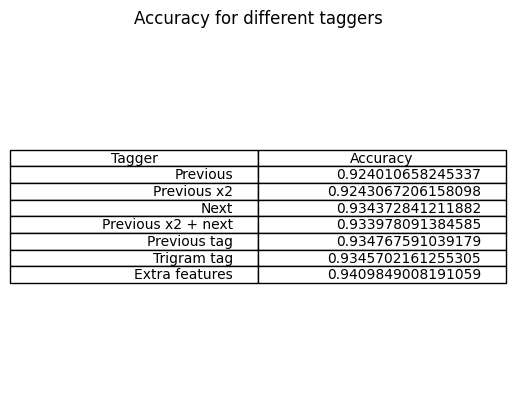

In [314]:
accuracies_taggers = [accuracy_2a, accuracy_2b_prev2, accuracy_2b_next, accuracy_2b_prev2_next, accuracy_2c_tag, accuracy_2c_trigram, accuracy_2d_cap_num]
taggers = ["Previous", "Previous x2", "Next", "Previous x2 + next", "Previous tag", "Trigram tag", "Extra features"]
dictionary = {"Tagger": taggers, "Accuracy": accuracies_taggers}
df_accuracies = pd.DataFrame(dictionary)
df_accuracies

fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText = df_accuracies.values, colLabels = df_accuracies.columns, loc = 'center')
ax.set_title("Accuracy for different taggers")
plt.show()

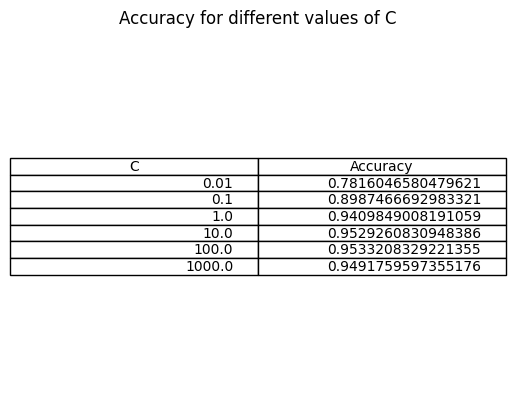

In [315]:
c = {"C": c_values, "Accuracy": accuracies}
df_c = pd.DataFrame(c)

fig, ax = plt.subplots(1, 1)
ax.axis('off')
ax.axis('tight')
ax.table(cellText = df_c.values, colLabels = df_c.columns, loc = 'center')
ax.set_title("Accuracy for different values of C")
plt.show()

The two tables above allow to summarize the results obtained by now. The best model in general is the one containing also the extra features. Its performance is even improved by setting the correct regularization. In this case, the best result is obtained with $C = 100.0$, where the accuracy of the tagger reaches 95,33%. 

Although I reached a high level of accuracy, I wasn't able to outperform the performance of the Perceptron tagger. I think that ....... why?:.....

**Part	3	– Training	and	testing	on	a	larger	corpus**

The Brown corpus covers 15 different genres, but we have only explored the news genre so far. In this 
part, we will retrain the most promising taggers on an extended set of genres and test them on held-out 
data.


**Exercise	3a:	Compile	the	extended	training	and	test	data**

The NLTK book, chapter 2.1.3, lists the names of the 15 genres available in the Brown corpus. We will set 
two genres aside for testing: hobbies and adventure. For training, we will use the news training set 
prepared for the previous exercises, as well as the data from the remaining 12 genres. Prepare the 
corpus as described and store the datasets in the variables all_train, hobbies_test and 
adventure_test. We will not use news_val in this part. Make sure to use the universal tagset.

In [316]:
all_train = brown.tagged_sents(categories = ['news', 'editorial', 'reviews', 'religion', 'lore', 'belles_lettres', 
                                             'government', 'crime', 'science_fiction', 'romance', 'humor', 'learned', 'mystery'], 
                                             tagset = 'universal')
hobbies_test = brown.tagged_sents(categories = 'hobbies', tagset = 'universal')
adventure_test = brown.tagged_sents(categories = 'adventure', tagset = 'universal')

**Exercise	3b:	Evaluate	the	taggers**

Identify the most successful tagger from part 1 and the best setup from part 2. Retrain both of them on 
all_train and evaluate them separately on the two test genres. Report the results and discuss them 
briefly: Which of the two genres is “easier”? How well do the two taggers generalize to unseen genres?


In [317]:
# Results with most successful tagger from part 1
perc = nltk.PerceptronTagger(load = False)
perc.train(all_train)
perc_accuracy_h = perc.accuracy(hobbies_test)
print("Accuracy hobbies:")
print(perc_accuracy_h)
perc_accuracy_a = perc.accuracy(adventure_test)
print("Accuracy adventures:")
print(perc_accuracy_a)

Accuracy hobbies:
0.9674297164369421
Accuracy adventures:
0.9735658042744657


In [318]:
# Results with most successful tagger from part 2
tagger = ScikitGreedyTagger(pos_features_cap_num, C = 100.0)
tagger.train(all_train)
accuracy_hobbies = tagger.accuracy(hobbies_test)
print("Accuracy hobbies:")
print(accuracy_hobbies)
accuracy_adventure = tagger.accuracy(adventure_test)
print("Accuracy adventures:") 
print(accuracy_adventure)

c:\Users\sanfe\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy hobbies:
0.9576537737567551
Accuracy adventures:
0.9651870439272014


Between the two genres, $adventure$ results to be the "easier" to predict, since the accuracy associated to this test set is higher than the one related to $hobbies$, with both the taggers. As before, the Perceptron tagger gives better results than the tagger from part 2: here the difference is just around 1% for both $hobbies$ and $adventure$. Therefore, the Perceptron tagger shows a better performance even with unseen data (even if the difference here is very small). 

**Exercise	3c:	Confusion	matrix**

The accuracy gives us a high-level overview of the performance of a tagger, but we may be interested in 
finding out more details about where the tagger makes the mistakes. The universal tagset is reasonably 
small, so we can produce a confusion matrix. Make a confusion matrix for the results. Pick the results of one test set and one tagger. Which pairs of tags are most easily confounded?

In [319]:
# confusion matrix for Perceptron tagger on the adventure test set
print(perc.confusion(adventure_test))

     |                             C           N           P           V       |
     |           A     A     A     O     D     O     N     R     P     E       |
     |           D     D     D     N     E     U     U     O     R     R       |
     |     .     J     P     V     J     T     N     M     N     T     B     X |
-----+-------------------------------------------------------------------------+
   . |<10929>    .     .     .     .     .     .     .     .     .     .     . |
 ADJ |     . <3020>    6   121     .     .   162     1     .     1    53     . |
 ADP |     .     8 <6902>   35     3     2    11     .     4    99     5     . |
 ADV |     .   116    53 <3585>    9    17    62     .     .    28     9     . |
CONJ |     .     1     5     1 <2152>   12     1     .     .     .     1     . |
 DET |     .     .    16    13     2 <8078>    3     2    40     .     1     . |
NOUN |     .   161     2    41     .     .<13020>   16     1     6   107     . |
 NUM |     .     1     .    

The columns of the matrix represents the predicted labels, while the rows are the real labels. In the diagonal, the number of correct predictions for ecah label is present. The other elements of the matrx, represents the number of miss-classifications for each couple of predicted and actual labels. Looking at this matrix, it is possible to see which are the most common mistakes made by our model. In this case, the highest numbers are:
1. 162 elements of the ADJ class have been wrongly predicted to be in the NOUN class
2. 161 elements of the NOUN class have been wrongly predicted to be in the ADJ class
3. 152 elements of the VERB class have been wrongly predicted to be in the NOUN class
4. 133 elements of the PRT class have been wrongly predicted to be in the ADP class
5. 121 elements of the ADJ class have been wrongly predicted to be in the ADV class
6. 107 elements of the NOUN class have been wrongly predicted to be in the VERB class

From these results, we can understand that the majority of the mistkes that our model does are:
- mixing NOUN and ADJ (due to 1. and 2.)
- mixing NOUN and VERB (due to 3. and 6.)

In addition, all the elements belonging the the $X$ class are miss-classified, as the last column of the matrix is empty (meaning that no element has been assigned to class $X$ in the prediction). 

Moreover, the class "$.$" is always predicted in the correct way.

However, the model has still high accuracy, since the number of total miss-classifications is way lower than the number of total correct classifications.

**Exercise	3d:	Precision,	recall	and	f-measure**

Finding hints on the NLTK web page linked above, calculate the precision, recall and f-measure for each 
tag and display the results in a table.

In [320]:
print(perc.evaluate_per_tag(adventure_test))

 Tag | Prec.  | Recall | F-measure
-----+--------+--------+-----------
   . | 1.0000 | 1.0000 | 1.0000
 ADJ | 0.9053 | 0.8977 | 0.9015
 ADP | 0.9672 | 0.9764 | 0.9718
 ADV | 0.9370 | 0.9242 | 0.9306
CONJ | 0.9931 | 0.9903 | 0.9917
 DET | 0.9855 | 0.9906 | 0.9880
NOUN | 0.9621 | 0.9750 | 0.9685
 NUM | 0.9585 | 0.9914 | 0.9747
PRON | 0.9911 | 0.9794 | 0.9852
 PRT | 0.9385 | 0.9019 | 0.9198
VERB | 0.9849 | 0.9831 | 0.9840
   X | 0.0000 | 0.0000 | 0.0000



In all cases, except for class $X$, all the values of Precision, Recall and F-measure are high and generally the values in ecach row are very similar to each other. The only exception is class $X$: here all the quantities are 0 (thus confirmimg what we have seen with the confusion matrix).

Also calculate the macro precision, macro recall and macro f-measure across all tags.

**Exercise	3e:	Error	analysis**

Sometimes, it makes sense to inspect the output of a machine learning model more thoroughly. Find five 
sentences in the test set where at least one token is misclassified and display these sentences in the 
following format, with both the predicted and gold tags.

In [352]:
tagged_words = brown.tagged_words(categories='adventure', tagset='universal')
sentences = brown.sents(categories='adventure')

In [369]:
tagged_words

('Dan', 'NOUN')

In [405]:
c = 0
for sentence in sentences:
    tag = tagged_words[c:c+len(sentence)]
    c = len(sentence)
    predicted = [tag for word, tag in perc.tag(sentence)]
    print(predicted)
    if any(pred != gold for pred, gold in zip(predicted, tag)):
    #for pred in predicted:
    #    for word, gold in tag:
    #        if pred != gold:
                print(f"Word: {word}\tPredicted Tag: {pred}\tGold Tag: {gold}")
    

['NOUN', 'NOUN', 'VERB', 'PRON', 'PRON', 'VERB', 'VERB', 'NOUN', 'NOUN', '.']
Word: Turner	Predicted Tag: .	Gold Tag: NOUN
['PRON', 'VERB', 'ADV', 'ADJ', 'ADP', 'PRON', '.']
Word: Turner	Predicted Tag: .	Gold Tag: NOUN
['PRON', 'ADV', 'VERB', 'VERB', 'DET', 'NOUN', 'PRON', 'VERB', 'NOUN', 'ADP', 'NOUN', '.']
Word: Turner	Predicted Tag: .	Gold Tag: NOUN
['ADP', 'PRON', 'VERB', 'VERB', 'PRON', '.', 'PRT', 'VERB', 'VERB', 'VERB', 'ADP', 'NOUN', '.']
Word: Turner	Predicted Tag: .	Gold Tag: NOUN
['CONJ', 'PRT', 'ADP', 'DET', 'VERB', 'NOUN', '.']
Word: Turner	Predicted Tag: .	Gold Tag: NOUN
['ADV', 'PRON', 'VERB', 'PRT', 'ADP', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'NOUN', 'ADP', 'NOUN', '.', 'CONJ', 'ADV', 'VERB', 'ADV', 'VERB', 'ADV', 'ADP', 'NOUN', '.']
Word: Turner	Predicted Tag: .	Gold Tag: NOUN
['DET', 'NOUN', 'CONJ', 'NOUN', 'VERB', 'VERB', 'ADP', 'PRON', 'ADV', 'ADJ', 'CONJ', 'ADP', 'ADV', 'ADJ', 'ADP', 'ADV', 'PRON', 'VERB', 'ADP', 'ADP', 'PRON', 'VERB', 'NOUN', '.']
Word: Turner	Pre

In [406]:
# Initialize a counter for misclassified sentences
misclassified_count = 0
i = 1
c = 0

for sentence, tag in zip(sentences, tagged_words):
    predicted = [tag for word, tag in perc.tag(sentence)]
    tag = tagged_words[c:c+len(sentence)]
    c = len(sentence)
    if any (predicted_tag != gold_tag[1] for predicted_tag, gold_tag in zip(predicted, tag)):
        print(predicted_tag, gold_tag[1])
        print("Sentence", i, ":")
        for word, predicted_tag, gold_tag in zip(sentence, predicted, tagged_words):
            print(f"Word: {word}\tPredicted Tag: {predicted_tag}\tGold Tag: {gold_tag[1]}")
        print("\n")
        misclassified_count += 1
        i += 1
    # Stop after finding five misclassified sentences
    if misclassified_count == 5:
        break

. NOUN
Sentence 1 :
Word: He	Predicted Tag: PRON	Gold Tag: NOUN
Word: certainly	Predicted Tag: ADV	Gold Tag: NOUN
Word: didn't	Predicted Tag: VERB	Gold Tag: VERB
Word: want	Predicted Tag: VERB	Gold Tag: PRON
Word: a	Predicted Tag: DET	Gold Tag: PRON
Word: wife	Predicted Tag: NOUN	Gold Tag: VERB
Word: who	Predicted Tag: PRON	Gold Tag: VERB
Word: was	Predicted Tag: VERB	Gold Tag: NOUN
Word: fickle	Predicted Tag: NOUN	Gold Tag: NOUN
Word: as	Predicted Tag: ADP	Gold Tag: .
Word: Ann	Predicted Tag: NOUN	Gold Tag: PRON
Word: .	Predicted Tag: .	Gold Tag: VERB


. VERB
Sentence 2 :
Word: If	Predicted Tag: ADP	Gold Tag: NOUN
Word: he	Predicted Tag: PRON	Gold Tag: NOUN
Word: had	Predicted Tag: VERB	Gold Tag: VERB
Word: married	Predicted Tag: VERB	Gold Tag: PRON
Word: her	Predicted Tag: PRON	Gold Tag: PRON
Word: ,	Predicted Tag: .	Gold Tag: VERB
Word: he'd	Predicted Tag: PRT	Gold Tag: VERB
Word: have	Predicted Tag: VERB	Gold Tag: NOUN
Word: been	Predicted Tag: VERB	Gold Tag: NOUN
Word: asking	Pre

In [362]:
# Initialize a counter for misclassified sentences
misclassified_count = 0
i = 1

for sentence, tag in zip(sentences, tagged_words):
    predicted = [tag for word, tag in perc.tag(sentence)]
    if any (predicted_tag != gold_tag[1] for predicted_tag, gold_tag in zip(predicted, tagged_words)):
        print(predicted_tag, gold_tag[1])
        print("Sentence", i, ":")
        #for word, predicted_tag, gold_tag in zip(sentence, predicted, tagged_words):
        #    print(f"Word: {word}\tPredicted Tag: {predicted_tag}\tGold Tag: {gold_tag[1]}")
        #print("\n")
        misclassified_count += 1
        i += 1
    # Stop after finding five misclassified sentences
    if misclassified_count == 5:
        break

. NOUN
Sentence 1 :
. NOUN
Sentence 2 :
. NOUN
Sentence 3 :
. NOUN
Sentence 4 :
. NOUN
Sentence 5 :


In [360]:
misclassified_count = 0

# Initialize a list to store misclassified tokens

misclassified_dfs = []
misclassified_tokens = []

for sentence, gold_tag in zip(sentences, tagged_words):
    predicted = [tag for word, tag in perc.tag(sentence)]
    if any(predicted_tag != gold_tag for predicted_tag, (_, gold_tag) in zip(predicted, tagged_words)):
        
        for word, predicted_tag, (_, gold_tag) in zip(sentence, predicted, tagged_words):
            misclassified_tokens.append([word, predicted_tag, gold_tag])

        # Create a DataFrame from the list of misclassified tokens
        df = pd.DataFrame(misclassified_tokens, columns = ["Token", "Predicted Tag", "Gold Tag"])
        misclassified_dfs.append(df)
        misclassified_count += 1
        misclassified_tokens = []
    # Stop after finding five misclassified sentences
    if misclassified_count == 5:
        break

# Access and print each DataFrame in the list
for i in range(len(misclassified_dfs)):
    print(f"Misclassified Sentence {i+1}:")
    print(misclassified_dfs[i])
    print("\n")

Misclassified Sentence 1:
  Token Predicted Tag Gold Tag
0    He          PRON     NOUN
1   was          VERB     NOUN
2  well           ADV     VERB
3   rid           ADJ     PRON
4    of           ADP     PRON
5   her          PRON     VERB
6     .             .     VERB


Misclassified Sentence 2:
        Token Predicted Tag Gold Tag
0          He          PRON     NOUN
1   certainly           ADV     NOUN
2      didn't          VERB     VERB
3        want          VERB     PRON
4           a           DET     PRON
5        wife          NOUN     VERB
6         who          PRON     VERB
7         was          VERB     NOUN
8      fickle          NOUN     NOUN
9          as           ADP        .
10        Ann          NOUN     PRON
11          .             .     VERB


Misclassified Sentence 3:
      Token Predicted Tag Gold Tag
0        If           ADP     NOUN
1        he          PRON     NOUN
2       had          VERB     VERB
3   married          VERB     PRON
4       her   

Identify the words that are tagged differently. Comment on each of the differences. Would you say that 
the predicted tag is wrong? Or is there a genuine ambiguity such that both answers are defendable? Or is 
even the gold tag wrong?

-  SENTENCE 1: 
1. he: predicted as PRON, gold tag is NOUN -> our model is correct, since he is a pronuon
2. was: predicted as 

- SENTENCE 2:

- SENTENCE 3:

- SENTENCE 4:

- SENTENCE 5: